In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

##Initializing path for train and validation data

In [2]:
train_ges = '/content/drive/My Drive/soc_ges/train_ges'
val_ges = '/content/drive/My Drive/soc_ges/val_ges'

##Instantiating the VGG16 convolutional base

In [3]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(150, 150, 3))

Using TensorFlow backend.


##Adding a densely connected classifier on top of the convolutional base

In [4]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

###Setting conv_base parameters as non-trainable parameters

In [5]:
model.layers[0].trainable = False

In [6]:
input_shape = (150,150,3)
model.build(input_shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 16,813,124
Trainable params: 2,098,436
Non-trainable params: 14,714,688
_________________________________________________________________


##Training the model along with data augumentation

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
train_ges,
target_size=(150, 150),
batch_size=10,
class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
val_ges,
target_size=(150, 150),
batch_size=10,
class_mode='categorical')

model.compile(loss='categorical_crossentropy',
optimizer=optimizers.RMSprop(lr=0.00001),
metrics=['acc'])

history = model.fit_generator(
train_generator,
steps_per_epoch=100,
epochs=20,
validation_data=validation_generator,
validation_steps=50)

Found 800 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Epoch 1/20
100/100 [==============================] - 14s 137ms/step - loss: 1.0339 - acc: 0.7860 - val_loss: 0.9040 - val_acc: 0.8320
Epoch 2/20
100/100 [==============================] - 10s 102ms/step - loss: 0.5635 - acc: 0.9940 - val_loss: 0.6358 - val_acc: 0.9540
Epoch 3/20
100/100 [==============================] - 10s 99ms/step - loss: 0.2951 - acc: 0.9960 - val_loss: 0.2554 - val_acc: 0.9620
Epoch 4/20
100/100 [==============================] - 10s 101ms/step - loss: 0.1625 - acc: 0.9930 - val_loss: 0.2350 - val_acc: 0.9680
Epoch 5/20
100/100 [==============================] - 10s 101ms/step - loss: 0.0948 - acc: 0.9970 - val_loss: 0.1293 - val_acc: 0.9640
Epoch 6/20
100/100 [==============================] - 10s 99ms/step - loss: 0.0612 - acc: 0.9990 - val_loss: 0.2498 - val_acc: 0.9700
Epoch 7/20
100/100 [==============================] - 10s 98ms/step - loss: 0.0411 - acc: 0.9990 - val_loss: 0

###Freezing all layers up to a specific one

In [8]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [9]:
input_shape = (150,150,3)
model.build(input_shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 9,733,700
Trainable params: 2,098,436
Non-trainable params: 7,635,264
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


##Training our new model: Fine Tuning

In [10]:
model.compile(loss='categorical_crossentropy',
optimizer=optimizers.RMSprop(lr=0.0000001),
metrics=['acc'])

history = model.fit_generator(
train_generator,
steps_per_epoch=100,
epochs=20,
validation_data=validation_generator,
validation_steps=50)

Epoch 1/20
100/100 [==============================] - 12s 118ms/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.2018 - val_acc: 0.9640
Epoch 2/20
100/100 [==============================] - 11s 109ms/step - loss: 0.0045 - acc: 0.9990 - val_loss: 9.1352e-04 - val_acc: 0.9700
Epoch 3/20
100/100 [==============================] - 11s 108ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0091 - val_acc: 0.9680
Epoch 4/20
100/100 [==============================] - 11s 109ms/step - loss: 0.0032 - acc: 0.9990 - val_loss: 0.0111 - val_acc: 0.9680
Epoch 5/20
100/100 [==============================] - 11s 107ms/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0118 - val_acc: 0.9700
Epoch 6/20
100/100 [==============================] - 11s 107ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.2897 - val_acc: 0.9700
Epoch 7/20
100/100 [==============================] - 11s 107ms/step - loss: 0.0028 - acc: 0.9990 - val_loss: 0.2815 - val_acc: 0.9660
Epoch 8/20
100/100 [==============================]

In [11]:
model.save('Transfer_ges.h5')

##PLotting the results

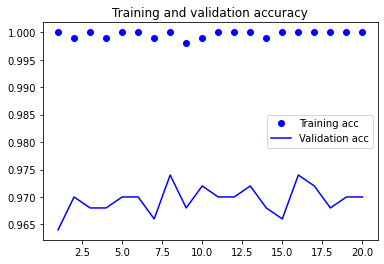

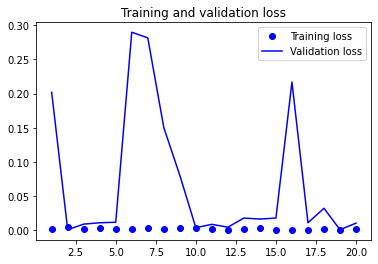

In [12]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

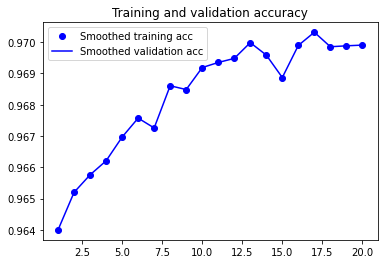

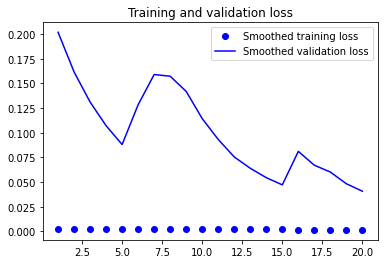

In [13]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points
plt.plot(epochs,
smooth_curve(val_acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,
smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#Thus we got 97% accuracy in classifying hand gesture using model based on pretrained convolutional network.